In [ ]:
!pip install --upgrade sagemaker awscli boto3 pandas Pillow==7.1.2 -i https://pypi.tuna.tsinghua.edu.cn/simple

In [ ]:
!pip uninstall -y tqdm

## Data preparation

In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

from code.dataloader import get_dataloader

In [2]:
dataroot = './data'

# down load dataset if not exist
trainset = torchvision.datasets.CIFAR10(root=dataroot, train=True, download=True)
testset = torchvision.datasets.CIFAR10(root=dataroot, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


* upload dataset to s3

In [3]:
import os
from sagemaker.s3 import S3Uploader as s3up

# S3 bucket for saving code and model artifacts.
bucket = 'flow-sagemaker-bucket'

s3_data_location = s3up.upload(os.path.join(dataroot, "cifar-10-batches-py"), f"s3://{bucket}/data/cifar-10-batches-py")
print('Updload to {0}'.format(s3_data_location))

Updload to s3://flow-sagemaker-bucket/data/cifar-10-batches-py


## A. Hyper paramter tunning

In [4]:
from sagemaker import get_execution_role

# IAM execution role that gives SageMaker access to resources in your AWS account.
# We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()
print('Use IAM role {0}'.format(role))

Use IAM role arn:aws:iam::843456404290:role/service-role/AmazonSageMaker-ExecutionRole-20190516T112244


In [5]:
from sagemaker.pytorch import PyTorch

# Location to save your custom code in tar.gz format.
s3_custom_code_upload_location = f's3://{bucket}/code'

# Location where results of model training are saved.
s3_model_artifacts_location = f's3://{bucket}/models/'

estimator = PyTorch(role=role,
                    entry_point='train.py',
                    source_dir='./code',
                    output_path=s3_model_artifacts_location,
                    code_location=s3_custom_code_upload_location,
                    instance_count=1,
                    instance_type='ml.p3.2xlarge',
                    use_spot_instances=True,
                    max_wait=86400,
                    framework_version='1.5.0',
                    py_version='py3',
#                     hyperparameters=hps,
                   )

In [6]:
hyperparameter_ranges = {'lr': ContinuousParameter(0.001, 0.1),'batch-size': CategoricalParameter([32,64,128,256,512])}

In [7]:
objective_metric_name = 'average test loss'
objective_type = 'Minimize'
# use Regex to extract loss from log
metric_definitions = [{'Name': 'average test loss',
                       'Regex': 'Test set: Average loss: ([0-9\\.]+)'}]

In [8]:
# max_jobs will sample hyperparameter_ranges into specify job number
tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=9,
                            max_parallel_jobs=2,
                            objective_type=objective_type)

In [9]:
tuner.fit({'training': s3_data_location})

.......................................................................................................................................................................................................................................................................................................................................................................................!


## B. Track hyperparameter tuning job progress
* After you launch a tuning job, you can see its progress by calling describe_tuning_job API.
* The output from describe-tuning-job is a JSON object that contains information about the current state of the tuning job(see section 2 below)
* You can call list_training_jobs_for_tuning_job to see a detailed list of the training jobs that the tuning job launched(see section 1 below).

In [10]:
import os
import boto3
import sagemaker

In [11]:
region = boto3.Session().region_name
sage_client = boto3.Session().client('sagemaker')

In [12]:
## You must have already run a hyperparameter tuning job to analyze it here.
## The Hyperparameter tuning jobs you have run are listed in the Training section on your SageMaker dashboard.
## Copy the name of a completed job you want to analyze from that list.
## For example: tuning_job_name = 'mxnet-training-201007-0054'.
tuning_job_name = 'pytorch-training-201230-1148'

## 1. Track all tunning jobs

In [14]:
from sagemaker.estimator import Estimator

all_jobs_info = sage_client.list_training_jobs_for_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
# track first tunning
sub_jobs_info = all_jobs_info['TrainingJobSummaries'][0]

attached_estimator = Estimator.attach(sub_jobs_info['TrainingJobName'])
attached_estimator


2020-12-30 12:19:22 Starting - Preparing the instances for training
2020-12-30 12:19:22 Downloading - Downloading input data
2020-12-30 12:19:22 Training - Training image download completed. Training in progress.
2020-12-30 12:19:22 Uploading - Uploading generated training model
2020-12-30 12:19:22 Completed - Training job completed


## 2. Tracking tunning state

In [22]:
# run this cell to check current status of hyperparameter tuning job
tuning_job_result = sage_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']
print('is_minimize:{0}, objective name{1}'.format(is_minimize, objective_name))

9 training jobs have completed
is_minimize:True, objective nameaverage test loss


In [23]:
from pprint import pprint
if tuning_job_result.get('BestTrainingJob',None):
    print("Best model found so far:")
    pprint(tuning_job_result['BestTrainingJob'])
else:
    print("No training jobs have reported results yet.")

Best model found so far:
{'CreationTime': datetime.datetime(2020, 12, 30, 11, 54, 37, tzinfo=tzlocal()),
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'average test '
                                                               'loss',
                                                 'Value': 2.2894999980926514},
 'ObjectiveStatus': 'Succeeded',
 'TrainingEndTime': datetime.datetime(2020, 12, 30, 12, 0, 4, tzinfo=tzlocal()),
 'TrainingJobArn': 'arn:aws:sagemaker:ap-northeast-1:843456404290:training-job/pytorch-training-201230-1148-003-7de4e459',
 'TrainingJobName': 'pytorch-training-201230-1148-003-7de4e459',
 'TrainingJobStatus': 'Completed',
 'TrainingStartTime': datetime.datetime(2020, 12, 30, 11, 57, 3, tzinfo=tzlocal()),
 'TunedHyperParameters': {'batch-size': '"256"', 'lr': '0.001297084130092771'}}


## Fetch all results as DataFrame
* We can list hyperparameters and objective metrics of all training jobs and pick up the training job with the best objective metric.

In [24]:
import pandas as pd

tuner_info = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_info.dataframe()

if len(full_df) > 0:
    df = full_df[full_df['FinalObjectiveValue'] > -float('inf')]
    if len(df) > 0:
        df = df.sort_values('FinalObjectiveValue', ascending=is_minimize)
        print("Number of training jobs with valid objective: %d" % len(df))
        print({"lowest":min(df['FinalObjectiveValue']),"highest": max(df['FinalObjectiveValue'])})
        pd.set_option('display.max_colwidth', -1)  # Don't truncate TrainingJobName        
    else:
        print("No training jobs have reported valid results yet.")
        
df

Number of training jobs with valid objective: 9
{'lowest': 2.2894999980926514, 'highest': 2.3096001148223877}


,batch-size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
6,"""256""",0.001297,pytorch-training-201230-1148-003-7de4e459,Completed,2.2895,2020-12-30 11:57:03+00:00,2020-12-30 12:00:04+00:00,181.0
7,"""256""",0.001713,pytorch-training-201230-1148-002-b13ed748,Completed,2.2955,2020-12-30 11:51:15+00:00,2020-12-30 11:54:16+00:00,181.0
2,"""64""",0.014973,pytorch-training-201230-1148-007-42d5e596,Completed,2.2989,2020-12-30 12:09:34+00:00,2020-12-30 12:12:36+00:00,182.0
8,"""256""",0.004586,pytorch-training-201230-1148-001-d7e279dc,Completed,2.3046,2020-12-30 11:50:56+00:00,2020-12-30 11:53:52+00:00,176.0
0,"""128""",0.099080,pytorch-training-201230-1148-009-b457940d,Completed,2.3059,2020-12-30 12:16:16+00:00,2020-12-30 12:19:22+00:00,186.0
4,"""256""",0.001000,pytorch-training-201230-1148-005-7c96a996,Completed,2.3089,2020-12-30 12:04:21+00:00,2020-12-30 12:07:17+00:00,176.0
1,"""64""",0.014299,pytorch-training-201230-1148-008-d7878ef8,Completed,2.3091,2020-12-30 12:10:08+00:00,2020-12-30 12:13:10+00:00,182.0
3,"""256""",0.001010,pytorch-training-201230-1148-006-8f209098,Completed,2.3095,2020-12-30 12:03:16+00:00,2020-12-30 12:06:11+00:00,175.0
5,"""512""",0.001254,pytorch-training-201230-1148-004-213737ce,Completed,2.3096,2020-12-30 11:57:29+00:00,2020-12-30 12:00:15+00:00,166.0


## See TuningJob results vs time
Next we will show how the objective metric changes over time, as the tuning job progresses.
For Bayesian strategy, you should expect to see a general trend towards better results, but this progress will not be steady as the algorithm needs to balance exploration of new areas of parameter space against exploitation of known good areas. This can give you a sense of whether or not the number of training jobs is sufficient for the complexity of your search space.

In [25]:
import bokeh
import bokeh.io
bokeh.io.output_notebook()
from bokeh.plotting import figure, show
from bokeh.models import HoverTool

class HoverHelper():

    def __init__(self, tuning_analytics):
        self.tuner = tuning_analytics

    def hovertool(self):
        tooltips = [
            ("FinalObjectiveValue", "@FinalObjectiveValue"),
            ("TrainingJobName", "@TrainingJobName"),
        ]
        for k in self.tuner.tuning_ranges.keys():
            tooltips.append( (k, "@{%s}" % k) )

        ht = HoverTool(tooltips=tooltips)
        return ht

    def tools(self, standard_tools='pan,crosshair,wheel_zoom,zoom_in,zoom_out,undo,reset'):
        return [self.hovertool(), standard_tools]

hover = HoverHelper(tuner_info)

p = figure(plot_width=900, plot_height=400, tools=hover.tools(), x_axis_type='datetime')
p.circle(source=df, x='TrainingStartTime', y='FinalObjectiveValue')
show(p)

Loading BokehJS ...

## Analyze the correlation between objective metric and individual hyperparameters
Now you have finished a tuning job, you may want to know the correlation between your objective metric and individual hyperparameters you've selected to tune. Having that insight will help you decide whether it makes sense to adjust search ranges for certain hyperparameters and start another tuning job. For example, if you see a positive trend between objective metric and a numerical hyperparameter, you probably want to set a higher tuning range for that hyperparameter in your next tuning job.

The following cell draws a graph for each hyperparameter to show its correlation with your objective metric.

In [26]:
ranges = tuner_info.tuning_ranges
figures = []
for hp_name, hp_range in ranges.items():
    categorical_args = {}
    if hp_range.get('Values'):
        # This is marked as categorical.  Check if all options are actually numbers.
        def is_num(x):
            try:
                float(x)
                return 1
            except:
                return 0           
        vals = hp_range['Values']
        if sum([is_num(x) for x in vals]) == len(vals):
            # Bokeh has issues plotting a "categorical" range that's actually numeric, so plot as numeric
            print("Hyperparameter %s is tuned as categorical, but all values are numeric" % hp_name)
        else:
            # Set up extra options for plotting categoricals.  A bit tricky when they're actually numbers.
            categorical_args['x_range'] = vals

    # Now plot it
    p = figure(plot_width=500, plot_height=500, 
               title="Objective vs %s" % hp_name,
               tools=hover.tools(),
               x_axis_label=hp_name, y_axis_label=objective_name,
               **categorical_args)
    p.circle(source=df, x=hp_name, y='FinalObjectiveValue')
    figures.append(p)
show(bokeh.layouts.Column(*figures))

## C. Deploy tunning job
* Deploy from best tunning job

In [20]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def get_data(data_root='./data'):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    testset = torchvision.datasets.CIFAR10(root=data_root, train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                             shuffle=False, num_workers=2)

    return testloader

In [15]:
# deploy best tunning job
predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


2020-12-31 09:27:00 Starting - Preparing the instances for training
2020-12-31 09:27:00 Downloading - Downloading input data
2020-12-31 09:27:00 Training - Training image download completed. Training in progress.
2020-12-31 09:27:00 Uploading - Uploading generated training model
2020-12-31 09:27:00 Completed - Training job completed
---------------!

Files already downloaded and verified


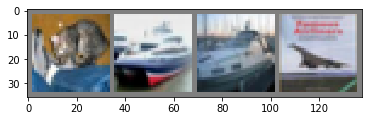

GroundTruth:   cat ship ship plane


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from model with message "Your invocation timed out while waiting for a response from container model. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://ap-northeast-1.console.aws.amazon.com/cloudwatch/home?region=ap-northeast-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-201231-0908-005-ea3ace00 in account 843456404290 for more information.

In [21]:
# Inference at end point
# fail: findout someday
import matplotlib.pyplot as plt

# get some test images
test_loader = get_data()
dataiter = iter(test_loader)
images, labels = dataiter.next()

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%4s' % classes[labels[j]] for j in range(4)))

outputs = predictor.predict(images.numpy())
_, predicted = torch.max(torch.from_numpy(np.array(outputs)), 1)
print('Predicted: ', ' '.join('%4s' % classes[predicted[j]] for j in range(4)))

* Deploy from specify job or best job by job ID

In [29]:
from sagemaker.estimator import Estimator

all_jobs_info = sage_client.list_training_jobs_for_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)
# track first tunning
sub_jobs_info = all_jobs_info['TrainingJobSummaries'][0]
print("get job {0}".format(sub_jobs_info['TrainingJobName']))
attached_estimator = Estimator.attach(sub_jobs_info['TrainingJobName'])
attached_estimator

get job pytorch-training-201230-1148-009-b457940d

2020-12-30 12:19:22 Starting - Preparing the instances for training
2020-12-30 12:19:22 Downloading - Downloading input data
2020-12-30 12:19:22 Training - Training image download completed. Training in progress.
2020-12-30 12:19:22 Uploading - Uploading generated training model
2020-12-30 12:19:22 Completed - Training job completed


In [ ]:
# fail TODO: find out some day
tic = time.time()
predictor = attached_estimator.deploy(instance_type='ml.t2.medium', # ml.m4.xlarge
                                      initial_instance_count=1,
                                      entry_point='inference.py'
                                     )
# predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
toc = time.time()
print(f'start predictor time: {toc - tic} s')